Usando imagen por defecto: https://th.bing.com/th/id/R.5944a0ca42dfaccdd5124bb9879ff53f?rik=tKM6Zzgo9oNxQg&riu=http%3a%2f%2fwww.planetacurioso.com%2fwp-content%2fuploads%2f2016%2f12%2fzorros-16-min.jpg&ehk=y2H71unSIWZLrelSeHvHTOYJtBKqJAzu6BCopQ39wqE%3d&risl=&pid=ImgRaw&r=0


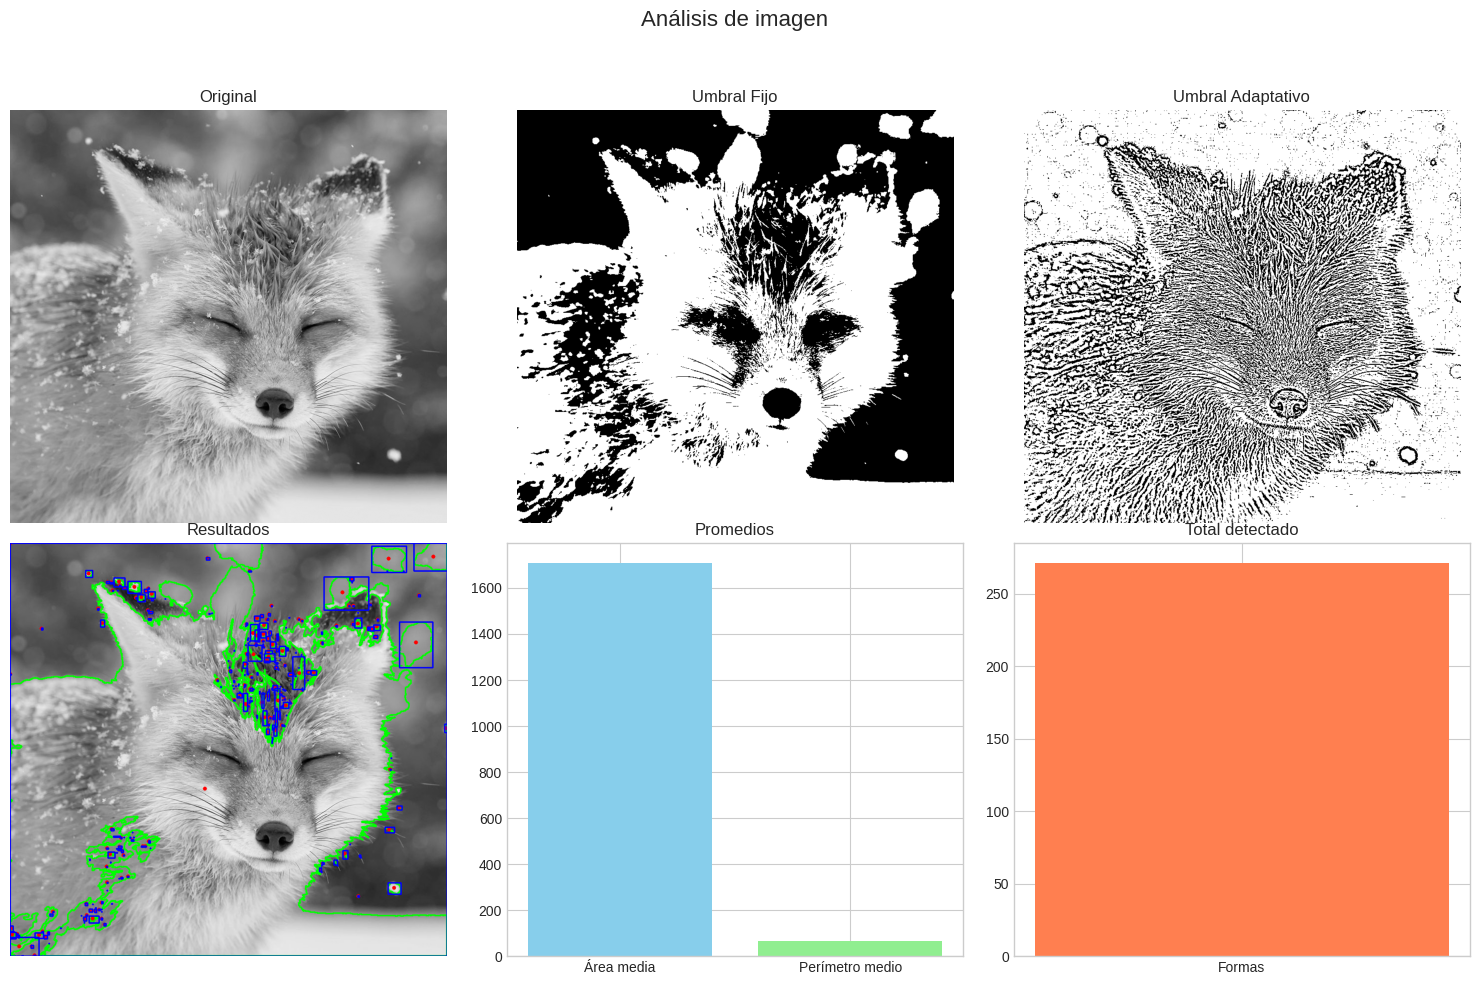

Formas: 271
Área media: 1708.33
Perímetro medio: 66.83


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import urllib.request
from google.colab import files

plt.style.use('seaborn-v0_8-whitegrid')

def obtener_imagen(fuente=None):
    url = "https://th.bing.com/th/id/R.5944a0ca42dfaccdd5124bb9879ff53f?rik=tKM6Zzgo9oNxQg&riu=http%3a%2f%2fwww.planetacurioso.com%2fwp-content%2fuploads%2f2016%2f12%2fzorros-16-min.jpg&ehk=y2H71unSIWZLrelSeHvHTOYJtBKqJAzu6BCopQ39wqE%3d&risl=&pid=ImgRaw&r=0"
    with urllib.request.urlopen(url) as resp:
        data = np.asarray(bytearray(resp.read()), dtype=np.uint8)
        imagen = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

    if imagen is None:
        raise IOError("Error al cargar la imagen.")
    return imagen

def umbralizar(imagen):
    _, fijo = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adaptativo = cv2.adaptiveThreshold(imagen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    return fijo, adaptativo

def encontrar_formas(binaria):
    formas, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return formas

def extraer_info(formas):
    resumen = {
        "conteo": len(formas),
        "areas": [],
        "perimetros": [],
        "centros": [],
        "cajas": []
    }

    for f in formas:
        resumen["areas"].append(cv2.contourArea(f))
        resumen["perimetros"].append(cv2.arcLength(f, True))

        M = cv2.moments(f)
        cx = int(M["m10"] / M["m00"]) if M["m00"] else 0
        cy = int(M["m01"] / M["m00"]) if M["m00"] else 0
        resumen["centros"].append((cx, cy))

        resumen["cajas"].append(cv2.boundingRect(f))

    resumen["area_media"] = np.mean(resumen["areas"]) if resumen["areas"] else 0
    resumen["perimetro_medio"] = np.mean(resumen["perimetros"]) if resumen["perimetros"] else 0
    return resumen

def superponer_datos(gris, formas, centros, cajas):
    copia = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(copia, formas, -1, (0, 255, 0), 2)

    for c in centros:
        cv2.circle(copia, c, 4, (0, 0, 255), -1)

    for x, y, w, h in cajas:
        cv2.rectangle(copia, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return copia

def mostrar_todo(original, fijo, adapt, resaltada, datos):
    fig, ejes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Análisis de imagen", fontsize=16)

    imgs = [
        (original, 'Original'),
        (fijo, 'Umbral Fijo'),
        (adapt, 'Umbral Adaptativo'),
        (cv2.cvtColor(resaltada, cv2.COLOR_BGR2RGB), 'Resultados')
    ]

    for idx, (img, titulo) in enumerate(imgs):
        ax = ejes[idx // 3][idx % 3]
        ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        ax.set_title(titulo)
        ax.axis('off')

    ejes[1][1].bar(['Área media', 'Perímetro medio'],
                   [datos['area_media'], datos['perimetro_medio']],
                   color=['skyblue', 'lightgreen'])
    ejes[1][1].set_title('Promedios')

    ejes[1][2].bar(['Formas'], [datos['conteo']], color='coral')
    ejes[1][2].set_title('Total detectado')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    print(f"Formas: {datos['conteo']}")
    print(f"Área media: {datos['area_media']:.2f}")
    print(f"Perímetro medio: {datos['perimetro_medio']:.2f}")

def ejecutar_pipeline(ubicacion=None):
    img = obtener_imagen(ubicacion)
    umbral1, umbral2 = umbralizar(img)
    formas = encontrar_formas(umbral1)
    datos = extraer_info(formas)
    resultado = superponer_datos(img, formas, datos['centros'], datos['cajas'])
    mostrar_todo(img, umbral1, umbral2, resultado, datos)
    return img, umbral1, umbral2, resultado, datos

# Lanzar el flujo
if __name__ == "__main__":
    ejecutar_pipeline()
